In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using JLD2

#### Examples: run one cell

In [2]:
### Example: forrelated vs random states ###

data = load("../data/old/forr_rand_fns_n4.jld2")

forr_f = data["single_stored_object"][1]
rand_f = data["single_stored_object"][2]

forr_batch, forr_samples, forr_vec = size(forr_f, 1), size(forr_f[1], 1), size(forr_f[1][1], 1)
rand_batch, rand_samples, rand_vec = size(rand_f, 1), size(rand_f[1], 1), size(rand_f[1][1], 1)

new_forr_f = zeros(Float64, forr_batch, forr_samples, forr_vec)
new_rand_f = zeros(Float64, rand_batch, rand_samples, rand_vec)

for i in 1:forr_batch
    for j in 1:forr_samples
        new_forr_f[i, j, :] = forr_f[i][j]
        new_rand_f[i, j, :] = rand_f[i][j]
    end
end

####### Change to Int -1, 1 ########
new_forr_f = trunc.(Int64, new_forr_f)
new_rand_f = trunc.(Int64, new_rand_f)
forr_f[1][1][:] ≈ new_forr_f[1,1,:] ? println("Loading data: successful") : println("Loading data: failed")
####################################

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
states2 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
psi_zero = zero_state(n)
# psi_zero = zero_state(trunc(Int, log2(n)))
for i in 1:2*n_samples
    states1[i] = (copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 2, :]))
    states2[i] = (copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 2, :]))
end
states1[1][1].state ≈ normalize(new_forr_f[1, 1, :]) ? println("Preparation hypergraph states: successful") : println("Preparation hypergraph states: failed")

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = DataSiamese(tr_states, tr_labels);
d2 = DataSiamese(te_states, te_labels);

Loading data: successful
Preparation hypergraph states: successful


#### Model parameters

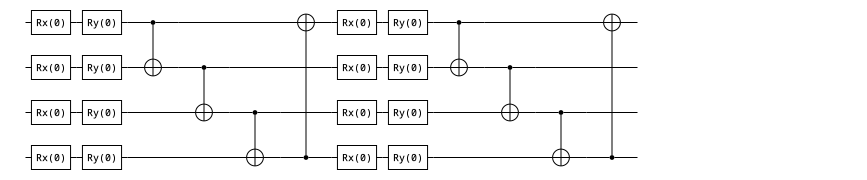

In [6]:
iters = 10 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function

##### QSCNN #####
# cost = overlap # overlap, swap_test, destructive_swap_test, entanglement_difference
# ansatz = conv_Ry # conv_Ry, conv_Ry2, conv_SU4
# circ = build_QCNN(n, ansatz=ansatz)
################

##### QSNN #####
cost = entanglement_difference # overlap, swap_test, destructive_swap_test, entanglement_difference
ansatz = circ_HEA
depth = ceil(Int, log2(n))
circ = build_QNN(n, depth, ansatz=ansatz)
###############

model = GeneralModel(n=n, circ=circ, ansatz=ansatz, cost=cost)
# model = InvariantModel(n=n, circ=circ, ansatz=ansatz, cost=cost)
initialize_params(model);

YaoPlots.plot(circ)
# YaoPlots.plot(cost(n))

MethodError: MethodError: no method matching entanglement_difference(::Int64)

Closest candidates are:
  entanglement_difference(!Matched::ArrayReg, !Matched::ArrayReg)
   @ Main.QComp ~/GitRepos/QComp.jl/src/Differencing.jl:53


#### Run

In [7]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, model, iters, optim; sig=sig, verbose=false)

Initial: loss = 0.9740691262526108, tr_acc = 0.5, te_acc = 0.5
Final: loss = 1.0398929813940143, tr_acc = 0.5, te_acc = 0.5


([3.6652912054398237, 5.030642003693437, 3.6735887363686563, 0.4009883300068932, 2.53203595813514, 0.3069828132001732, 3.7596944931288174, 3.1535523600084967, 1.627638740679452, 2.588110538189259, 3.561212133778559, 5.521472447994041, 0.13471631168857812, 2.278324672332569, 0.01961025839228415, 2.2235209186560994], [0.9740691262526108, 1.0173574680775699, 1.055605232550418, 1.0865847465106497, 1.104389450397393, 1.1019053916938102, 1.0957179936460066, 1.081899111534616, 1.0664192190101527, 1.0543259530038587, 1.0398929813940143], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], Any[0.1671645096882899, 0.3789170800913182, 0.11126208104575674, 0.26305876111088233, 0.01204882664320861, 0.29645895290303836, 0.008937612347035273, 0.7019568369296236, 0.20381019758688068, 0.0896964236785518  …  0.36307312390717583, 0.003544896803109099, 0.09096115519834291, 0.3491679998598247, 0.10833393420484061, 0.030018839257879737, 0.0230899

#### Plot

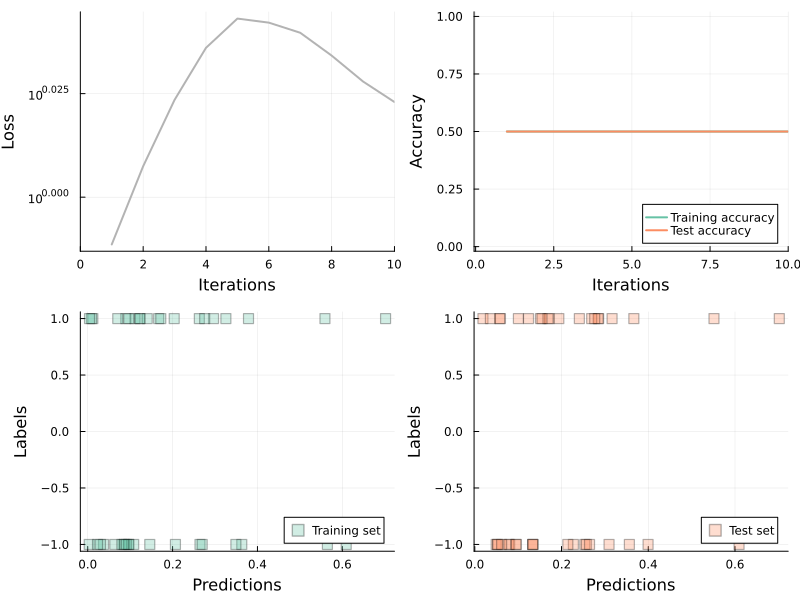

In [8]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [23]:
# savefig("qcsnn_forr_n4_conv_Ry_overlap.pdf")

"/home/stefano/GitRepos/QComp.jl/notebooks/qcsnn_forr_n4_conv_Ry_overlap.pdf"